In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import make_pipeline


In [13]:

df=pd.read_csv('spam.csv', encoding='latin1')

In [14]:

print(df.head())
print(df.shape)

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
(5572, 5)


In [15]:
df=df.dropna(axis=1)

In [16]:
print(df.head())
print(df.shape)
print(df.columns)


     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)
Index(['v1', 'v2'], dtype='object')


In [17]:
df['v1'] = df['v1'].str.strip().str.lower()
df['v1']=df['v1'].map({'ham':0,'spam':1})
print(df.head())

   v1                                                 v2
0   0  Go until jurong point, crazy.. Available only ...
1   0                      Ok lar... Joking wif u oni...
2   1  Free entry in 2 a wkly comp to win FA Cup fina...
3   0  U dun say so early hor... U c already then say...
4   0  Nah I don't think he goes to usf, he lives aro...


In [18]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


AttributeError: 'frozenset' object has no attribute 'words'

In [19]:
def pre_process(text):
  text=text.lower() #lowercase
  text = re.sub(r'[^a-z0-9 ]', ' ', text ) #keep only words and numbers to remove punctuation
  words=text.split()
  words=[word for word in words if word not in stop_words] #removed stopwords
  text=' '.join(words)
  return text


In [ ]:
df['v2']=df['v2'].astype(str).apply(pre_process)

In [21]:
print(df.head())

   v1                                                 v2
0   0  Go until jurong point, crazy.. Available only ...
1   0                      Ok lar... Joking wif u oni...
2   1  Free entry in 2 a wkly comp to win FA Cup fina...
3   0  U dun say so early hor... U c already then say...
4   0  Nah I don't think he goes to usf, he lives aro...


In [22]:
df['v1'].value_counts()

,count
v1,
0,4825
1,747


In [23]:
#first doing split before applying tf-idf to prevent leakage of data from test set
X_train, X_test, y_train, y_test = train_test_split(df['v2'],df['v1'],test_size=0.2, random_state=42)

In [24]:

tfidf=TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

In [25]:
#show class distribution
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))


Counter({0: 3860, 1: 597})
Counter({0: 965, 1: 150})


Train Accuracy: 0.8849001570563159
Test Accuracy: 0.8941704035874439
confusion matrix for testing:



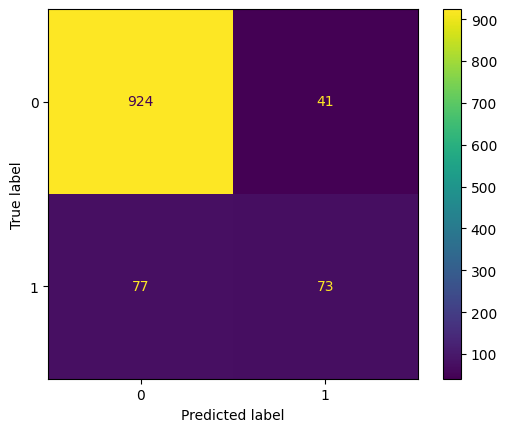

In [26]:

from sklearn.tree import DecisionTreeClassifier
stump=DecisionTreeClassifier(max_depth=1)
stump.fit(X_train_tfidf, y_train)

y_train_pred = stump.predict(X_train_tfidf)
y_test_pred = stump.predict(X_test_tfidf)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

print('confusion matrix for testing:\n')
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot()
plt.show()

Manual AdaBoost

In [27]:
def adaboost(T=15):
  #initialize weights
  N = X_train_tfidf.shape[0] #total no of rows
  weights = np.ones(N)/N #equal weight assigned to each sample and sum of all is 1
  alphas=[] #performance of the stumps
  errors=[] #total errors
  stumps=[] #stores all weak classifiers
  for t in range(1,T+1):
    print(f'iteration: {t}')

    stump_t = DecisionTreeClassifier(max_depth=1)
    # Use y_train.values to ensure consistent array-like input, preventing Pandas Series index issues
    stump_t.fit(X_train_tfidf, y_train.values, sample_weight=weights)
    pred=stump_t.predict(X_train_tfidf) # pred is numpy array
    stumps.append(stump_t)
    # Ensure comparisons are with numpy arrays to get numpy boolean arrays
    misclassified_mask=(pred!=y_train.values)
    mis_idx=np.where(misclassified_mask)[0] # indices of wrong predictions

    error_t = np.sum(weights[mis_idx]) # summation of all the sample weights of misclassified data points.
    errors.append(error_t)

    #print('Misclassified sample indices:', mis_idx)
    # print('Weights of misclassified samples:', weights[mis_idx])
    print(f'error{t}: {error_t}')

    # Handle the case where error_t is 0 or 1 to avoid log(0) or log of negative
    epsilon = 1e-10
    error_t = np.clip(error_t, epsilon, 1 - epsilon) # Clip error_t to avoid log issues

    alpha_t = 0.5*np.log((1-error_t)/error_t) #formula for performance
    alphas.append(alpha_t)
    print(f'alpha{t}: {alpha_t}')

    #update weights
    # Ensure this operation uses numpy arrays throughout
    exponent_term = -alpha_t * ((pred == y_train.values) * 2 - 1)
    weights = weights * np.exp(exponent_term)

    weights = weights/np.sum(weights) #normalize
  return alphas, errors, stumps

In [29]:
y_train_signed = np.where(y_train.values == 0, -1, 1)
train_scores = np.zeros(X_train_tfidf.shape[0])

alphas, errors, stumps = adaboost(T=15)

for alpha, stump in zip(alphas, stumps):
  pred = stump.predict(X_train_tfidf)
  pred_signed= np.where(pred == 0, -1, 1)
  train_scores += alpha * pred_signed
y_train_final = np.where(train_scores>=0, 1,0)

iteration: 1
error1: 0.11509984294368411
alpha1: 1.0198374352758781
iteration: 2
error2: 0.2556512421463847
alpha2: 0.5343477526318703
iteration: 3
error3: 0.3058826011897126
alpha3: 0.4097198683282769
iteration: 4
error4: 0.3398636633803225
alpha4: 0.33195091859462506
iteration: 5
error5: 0.3627219978138555
alpha5: 0.28178464495446687
iteration: 6
error6: 0.43217293818093083
alpha6: 0.13649553786600555
iteration: 7
error7: 0.40317866144302716
alpha7: 0.19611900542837463
iteration: 8
error8: 0.355695033351953
alpha8: 0.29704922443928045
iteration: 9
error9: 0.3924054482554796
alpha9: 0.21860609589886196
iteration: 10
error10: 0.39578716936984026
alpha10: 0.21152494438547376
iteration: 11
error11: 0.372103803719116
alpha11: 0.26160100132786585
iteration: 12
error12: 0.45760170638264824
alpha12: 0.08500071079691662
iteration: 13
error13: 0.427934610154867
alpha13: 0.14514144942966306
iteration: 14
error14: 0.43898322096970743
alpha14: 0.12264481145066368
iteration: 15
error15: 0.40744777

In [30]:
y_test_signed = np.where(y_test.values == 0, -1, 1)
test_scores = np.zeros((X_test_tfidf.shape[0]))

for alpha, stump in zip(alphas, stumps):
    pred = stump.predict(X_test_tfidf)
    pred_signed = np.where(pred == 1, 1, -1)
    test_scores += alpha * pred_signed

y_test_final = np.where(test_scores >= 0, 1, 0)

Final Train Accuracy: 0.925959165357864
Final Test Accuracy: 0.9381165919282511


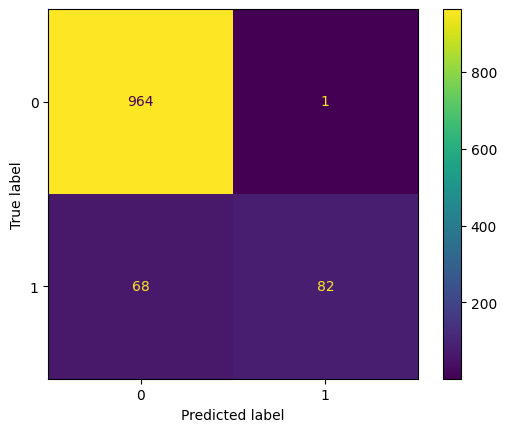

In [31]:
train_acc = accuracy_score(y_train, y_train_final)
test_acc = accuracy_score(y_test, y_test_final)

print("Final Train Accuracy:", train_acc)
print("Final Test Accuracy:", test_acc)

disp=ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_final))
disp.plot()
plt.show()

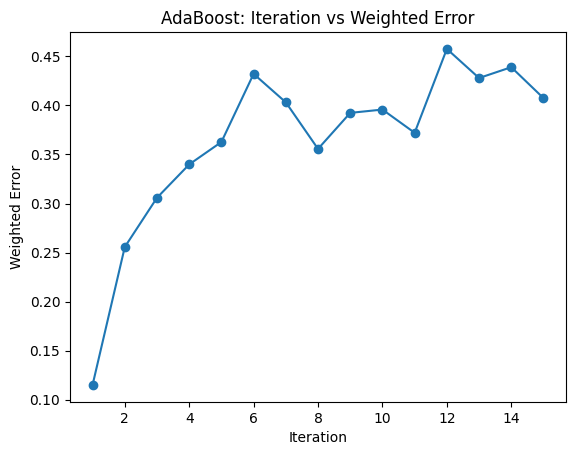

In [32]:

plt.plot(range(1, 16), errors, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.title("AdaBoost: Iteration vs Weighted Error")
plt.show()


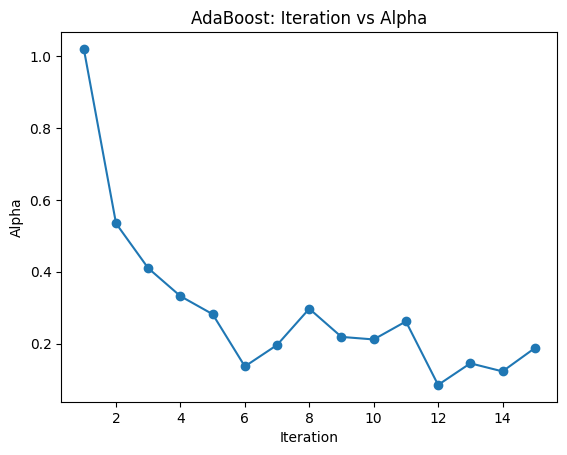

In [33]:
plt.plot(range(1, 16), alphas, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("AdaBoost: Iteration vs Alpha")
plt.show()

The weak learner has a low error in the first iteration, so AdaBoost gives it a high weight (large α). This means that the first stump has a big effect on the final model. As iterations go on, the mistakes get worse and stay between 0.3 and 0.45, which means that later stumps are only a little better than random. Because of this, their weights get smaller, which means they have less power. The weight evolution shows that AdaBoost learns the easy patterns in the data quickly but has trouble with the harder points later. This makes each new stump less helpful.

Train Accuracy : 0.941440430783038
Test Accuracy  : 0.9452914798206278

Confusion Matrix:



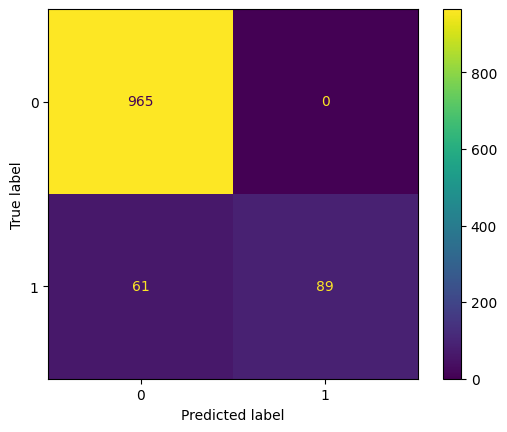

In [34]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)

ada.fit(X_train_tfidf, y_train)

y_train_pred = ada.predict(X_train_tfidf)
y_test_pred  = ada.predict(X_test_tfidf)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test, y_test_pred)


print("Train Accuracy :", train_acc)
print("Test Accuracy  :", test_acc)
print("\nConfusion Matrix:\n")
disp= ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot()
plt.show()

q2

In [35]:
!pip install ucimlrepo

In [36]:

from ucimlrepo import fetch_ucirepo

heart_disease = fetch_ucirepo(id=45)

X = heart_disease.data.features
y = heart_disease.data.targets

print(heart_disease.metadata)

print(heart_disease.variables)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [37]:

X.shape

(303, 13)

In [38]:
y

,num
0,0
1,2
2,1
3,0
4,0
...,...
298,1
299,2
300,3
301,1


In [39]:
y_binary = (y['num'] > 0).astype(int)
y_binary


,num
0,0
1,1
2,1
3,0
4,0
...,...
298,1
299,1
300,1
301,1


In [40]:
cat_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
num_cols = ['age','trestbps','chol','thalach','oldpeak']

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
#defining model with just one stump
model_stump = Pipeline(steps=[
    ('preprocess', preprocess),
    ('clf', stump)
])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

Training accuracy: 0.7479338842975206
Test accuracy: 0.8032786885245902

Confusion Matrix:


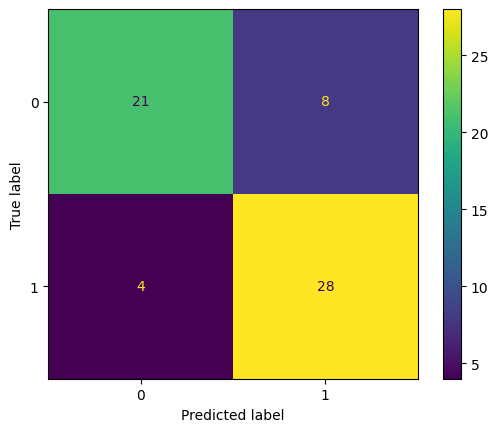


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78        29
           1       0.78      0.88      0.82        32

    accuracy                           0.80        61
   macro avg       0.81      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



In [42]:
model_stump.fit(X_train, y_train)
y_pred_train=model_stump.predict(X_train)
y_pred_test=model_stump.predict(X_test)
print("Training accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_test))

print("\nConfusion Matrix:")
disp=ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
disp.plot()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

In [43]:
X_train_transformed = preprocess.fit_transform(X_train)

X_test_transformed = preprocess.transform(X_test)


In [44]:
n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]
best_acc = 0
best_model = None
best_params = None

results = {lr: [] for lr in learning_rates}

for n in n_estimators_list:
    for lr in learning_rates:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr
        )
        model.fit(X_train_transformed, y_train)

        acc = model.score(X_test_transformed, y_test)
        results[lr].append(acc)

        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_params = (n, lr)

print("Best accuracy:", best_acc)
print("Best parameters:", best_params)

Best accuracy: 0.9016393442622951
Best parameters: (5, 0.1)


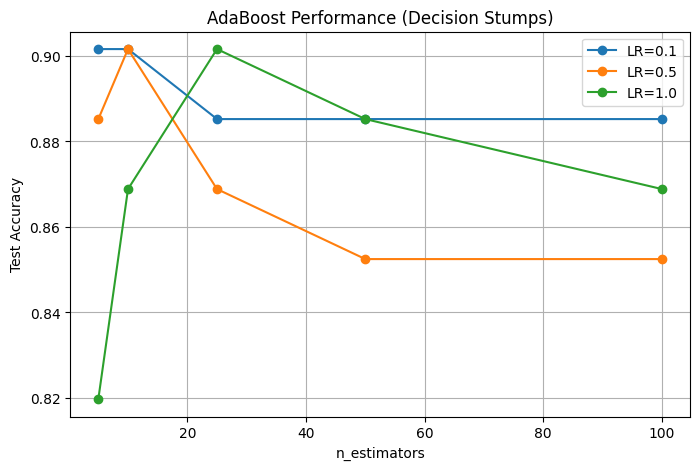

In [45]:
plt.figure(figsize=(8, 5))

for lr in learning_rates:
    plt.plot(n_estimators_list, results[lr], marker="o", label=f"LR={lr}")

plt.xlabel("n_estimators")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost Performance (Decision Stumps)")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
best_lr = 0.1
best_n  = 5

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr
)

pipe = make_pipeline(preprocess, ada)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('adaboostclassifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                    learning_rate=0.1, n_estimators=5))])

In [47]:
model = pipe.named_steps["adaboostclassifier"]

weak_errors = model.estimator_errors_          # ε_t
weak_alphas = model.estimator_weights_         # α_t

print("Weak learner errors:", weak_errors)
print("Estimator weights:", weak_alphas)


# Transform X_train the same way AdaBoost sees it to get per sample weights
X_train_transformed = pipe.named_steps["columntransformer"].transform(X_train)
y_train_arr = y_train.values

N = len(y_train_arr)
weights = np.ones(N) / N   # initial uniform weights

for stump, alpha in zip(model.estimators_, model.estimator_weights_):
    pred = stump.predict(X_train_transformed)
    incorrect = (pred != y_train_arr)
    weights *= np.exp(alpha * incorrect)
    # Normalize final weights
    weights /= weights.sum()

final_sample_weights = weights
print("Final sample weights (first 20):")
print(final_sample_weights[:20])

Weak learner errors: [0.25206612 0.25821562 0.27517596 0.27506027 0.28112972]
Estimator weights: [0.10876232 0.10552636 0.09685182 0.09690983 0.09388647]
Final sample weights (first 20):
[0.00359459 0.00483438 0.00396038 0.00359459 0.00593797 0.00396038
 0.00359459 0.00438787 0.00359459 0.00396038 0.00593797 0.00359459
 0.00441517 0.00441517 0.00441517 0.00483438 0.00359459 0.00441517
 0.00359459 0.00396038]


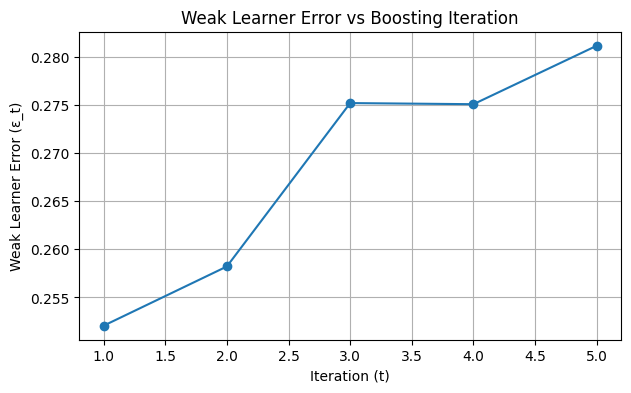

In [48]:
plt.figure(figsize=(7,4))
plt.plot(range(1, best_n+1), weak_errors, marker='o')
plt.xlabel("Iteration (t)")
plt.ylabel("Weak Learner Error (ε_t)")
plt.title("Weak Learner Error vs Boosting Iteration")
plt.grid(True)
plt.show()

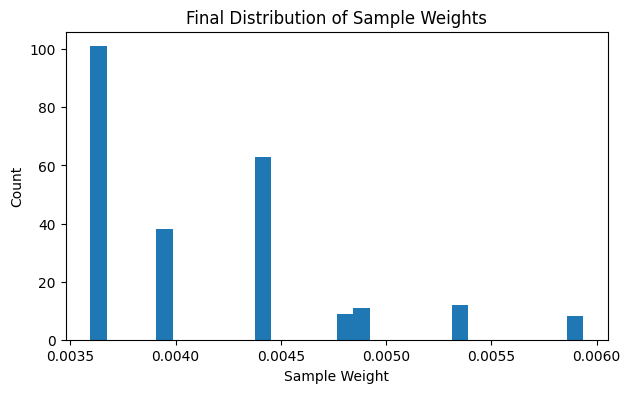

In [49]:
plt.figure(figsize=(7,4))
plt.hist(final_sample_weights, bins=30)
plt.xlabel("Sample Weight")
plt.ylabel("Count")
plt.title("Final Distribution of Sample Weights")
plt.show()


In [50]:
importances = model.feature_importances_

num_features = num_cols
cat_features = pipe.named_steps['columntransformer']\
                          .named_transformers_['cat']\
                          .get_feature_names_out(cat_cols)

all_features = np.concatenate([num_features, cat_features])

indices = np.argsort(importances)[::-1]
top5_idx = indices[:5]
top5_features = all_features[top5_idx]
top5_scores = importances[top5_idx]

print("Top 5 important features:")
for f, s in zip(top5_features, top5_scores):
    print(f"{f}: {s:.4f}")

Top 5 important features:
cp_4: 0.4096
thal_3.0: 0.3973
ca_0.0: 0.1931
thal_7.0: 0.0000
ca_nan: 0.0000


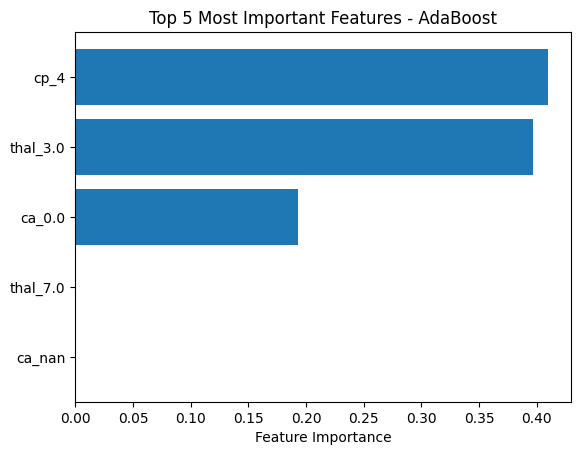

In [51]:

plt.barh(top5_features[::-1], top5_scores[::-1])  # reverse for descending top-to-bottom
plt.xlabel("Feature Importance")
plt.title("Top 5 Most Important Features - AdaBoost")
plt.show()

q3

In [ ]:
columns = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header=None, names=columns, on_bad_lines='skip')
df['z'] = df['z'].astype(str).str.replace(';', '', regex=False)
df['z'] = pd.to_numeric(df['z'], errors='coerce')
df.dropna(inplace=True)

vigorous = ['Jogging', 'Upstairs']
static = ['Walking', 'Sitting', 'Standing', 'Downstairs']

df = df[df['activity'].isin(vigorous + static)]
df['label'] = df['activity'].apply(lambda x: 1 if x in vigorous else 0)

X = df[['x', 'y', 'z']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

In [ ]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)
y_pred_stump = stump.predict(X_test)

print(accuracy_score(y_test, y_pred_stump))
print(confusion_matrix(y_test, y_pred_stump))

feature = ['x', 'y', 'z'][stump.tree_.feature[0]]
threshold = stump.tree_.threshold[0]
print(feature, threshold)

In [ ]:

n_estimators = 20
n_samples = len(X_train)
w = np.ones(n_samples) / n_samples
alphas = []
models = []
errors = []

for t in range(n_estimators):
    clf = DecisionTreeClassifier(max_depth=1, random_state=42)
    clf.fit(X_train, y_train, sample_weight=w)
    pred = clf.predict(X_train)

    miss = [int(x) for x in (pred != y_train)]
    err = np.dot(w, miss)
    err = max(err, 1e-10)

    alpha = 0.5 * np.log((1 - err) / err)
    alphas.append(alpha)
    models.append(clf)
    errors.append(err)

    print(f"Iter {t+1}: Error={err:.4f}, Alpha={alpha:.4f}, Misclassified={sum(miss)}")

    w *= np.exp(-alpha * (np.array(miss) * -1 + (1 - np.array(miss))))
    w /= np.sum(w)

In [ ]:
def manual_predict(X):
    final_pred = np.zeros(len(X))
    for alpha, model in zip(alphas, models):
        final_pred += alpha * (np.where(model.predict(X) == 0, -1, 1))
    return (np.sign(final_pred) == 1).astype(int)

y_pred_manual = manual_predict(X_test)
print(accuracy_score(y_test, y_pred_manual))
print(confusion_matrix(y_test, y_pred_manual))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_estimators + 1), errors, marker='o')
plt.subplot(1, 2, 2)
plt.plot(range(1, n_estimators + 1), alphas, marker='o', color='green')
plt.show()

In [ ]:
sk_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=1.0, algorithm='SAMME', random_state=42)
sk_ada.fit(X_train, y_train)
y_pred_sk = sk_ada.predict(X_test)

print(accuracy_score(y_test, y_pred_sk))
print(confusion_matrix(y_test, y_pred_sk))